# Urbansed

In [1]:
# Automatically reload modules before entering the execution of code typed at 
# the IPython prompt
%load_ext autoreload
%autoreload 2

In [5]:
# Import used libraries

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import librosa
import torch

torch.manual_seed(0)

print(f"{pd.__name__} version: {pd.__version__}")
print(f"{matplotlib.__name__} version: {matplotlib.__version__}")
print(f"{librosa.__name__} version: {librosa.__version__}")
print(f"{torch.__name__} version: {torch.__version__}")

pandas version: 2.1.2
matplotlib version: 3.8.3
librosa version: 0.10.2.post1
torch version: 2.4.0


In [44]:
from yoho.utils import AudioFile

def plot_melspectrogram(
    audio: AudioFile,
    n_mels: int = 40,
    win_len: float = 0.04,
    hop_len: float = 0.01,
):
    """
    Plots the Mel spectrogram.
    """
    plt.figure(figsize=(10, 4))
    plt.title(f"Mel spectrogram")
    librosa.display.specshow(
        data=audio.mel_spectrogram(
            n_mels=n_mels, win_len=win_len, hop_len=hop_len
        ),
        sr=audio.sr,
        x_axis="frames",
        y_axis="mel",
    )
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

## TUT Dataset

In [ ]:
from yoho.utils import AudioFile, UrbanSEDDataset

In [ ]:
urbansed_train = UrbanSEDDataset(
    audios=[
        audioclip
        for _, audio in enumerate(
            AudioFile(filepath=file.filepath, labels=eval(file.events))
            for _, file in pd.read_csv(
                "./data/raw/URBAN-SED/train.csv"
            ).iterrows()
        )
        for audioclip in audio.subdivide(win_len=2.56, hop_len=1.00)
    ]
)

urbansed_val = UrbanSEDDataset(
    audios=[
        audioclip
        for _, audio in enumerate(
            AudioFile(filepath=file.filepath, labels=eval(file.events))
            for _, file in pd.read_csv(
                "./data/raw/URBAN-SED/validate.csv"
            ).iterrows()
        )
        for audioclip in audio.subdivide(win_len=2.56, hop_len=1.00)
    ]
)

urbansed_test = UrbanSEDDataset(
    audios=[
        audioclip
        for _, audio in enumerate(
            AudioFile(filepath=file.filepath, labels=eval(file.events))
            for _, file in pd.read_csv(
                "./data/raw/URBAN-SED/test.csv"
            ).iterrows()
        )
        for audioclip in audio.subdivide(win_len=2.56, hop_len=1.00)
    ]
)

print(f"Number of audio clips in the train dataset: {len(urbansed_train)}")
print(f"Number of audio clips in the validation dataset: {len(urbansed_val)}")
print(f"Number of audio clips in the test dataset: {len(urbansed_test)}")
print(f"Duration of each audio clips: {urbansed_train.audios[0].duration} seconds")
print(f"Sampling rate of each audio clips: {urbansed_train.audios[0].sr} Hz")

In [7]:
audios = [
    AudioFile(filepath=file.filepath, labels=eval(file.events))
    for _, file in pd.read_csv("./data/raw/URBAN-SED/train.csv").iterrows()
]

In [13]:
from yoho.utils import AudioFile, UrbanSEDDataset

audioclips = [
    audioclip
    for audio in audios
    for audioclip in audio.subdivide(win_len=2.56, hop_len=1.00)
]

In [31]:
audioclips[8].labels

[('noise', 0, 2.0), ('street_music', 0, 1.9058476898372074)]

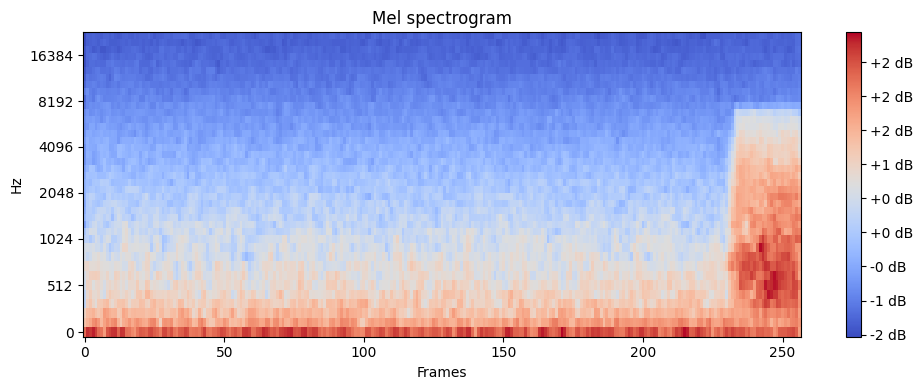

In [45]:
plot_melspectrogram(
    audio=audioclips[0],
)

In [40]:
audioclips[0].waveform.shape

(112896,)

In [ ]:
print(
    audios[0],
    audios[1],
    audios[2],
    audios[3],
    audios[4],
    audios[5],
    audios[6],
    audios[7],
    audios[8],
    audios[9],
    sep="\n"
)

## Data generator

In [ ]:
from yoho.utils import YOHODataGenerator

In [ ]:
train_dataloader = YOHODataGenerator(
    urbansed_train, batch_size=32, shuffle=True
)

val_dataloader = YOHODataGenerator(
    urbansed_val, batch_size=32, shuffle=False
)

train_features, train_labels = next(iter(train_dataloader))

print(f"Train features shape: {train_features.shape}")
print(f"Train labels shape: {train_labels.shape}")

## YOHO model

In [ ]:
from torchsummary import summary

from yoho.models import YOHO
from yoho.train import get_device

# Get the available device (cuda, mps or cpu)
device = get_device()

# Define the model
urbansed_model = YOHO(
    name="UrbanSEDYOHO",
    input_shape=(1, 40, 257), n_classes=len(urbansed_train.labels)
).to(device)

summary(
    urbansed_model,
    input_size=(1, 40, 257),
    batch_size=32,
)

## Training

In [ ]:
from yoho.train import load_checkpoint, train_model

# Get the optimizer
optimizer = urbansed_model.get_optimizer()

# Load the model checkpoint if it exists
urbansed_model, optimizer, start_epoch, _ = load_checkpoint(
    urbansed_model, optimizer
)

EPOCHS = 60
#train_model(
#        model=urbansed_model,
#        train_loader=train_dataloader,
#        val_loader=val_dataloader,
#        num_epochs=EPOCHS,
#        start_epoch=start_epoch,
#    )
urbansed_model.load(f"./models/{urbansed_model.name}_checkpoint.pth.tar", device)

## Evaluation

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to the losses.json file:

# Load the losses.json file
with open("./models/losses.json", "r") as f:
    losses = json.load(f)

# Extract epochs, train_loss, and val_loss
epochs = []
train_losses = []
val_losses = []

for epoch, metrics in losses.items():
    epochs.append(int(epoch))
    train_losses.append(metrics["train_loss"])
    val_losses.append(metrics["val_loss"])

# Sort the data by epochs to ensure correct plotting
epochs, train_losses, val_losses = zip(
    *sorted(zip(epochs, train_losses, val_losses))
)


# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = urbansed_model(train_features)

In [ ]:
import tensorflow as tf

def my_loss_fn(y_true, y_pred):

  squared_difference = tf.square(y_true - y_pred)

  ss_True = squared_difference[:, :, 0] * 0 + 1

  ss_0 = y_true[:, :, 0]
  ss_1 = y_true[:, :, 3]
  ss_2 = y_true[:, :, 6]
  ss_3 = y_true[:, :, 9]
  ss_4 = y_true[:, :, 12]
  ss_5 = y_true[:, :, 15]

  sss = tf.stack((ss_True, ss_0, ss_0,
                  ss_True, ss_1, ss_1,
                  ss_True, ss_2, ss_2,
                  ss_True, ss_3, ss_3,
                  ss_True, ss_4, ss_4,
                  ss_True, ss_5, ss_5), axis = 2)
  
  squared_difference =  tf.multiply(squared_difference, sss)

  return tf.reduce_sum(squared_difference, axis=[-1, -2])  # Note the `axis=-1`

In [ ]:
def custom_loss(target, output):
    """
    Custom loss function to compute the sum squared error.

    Parameters:
    target (torch.Tensor): The target tensor with shape (batch, 18, 9).
    output (torch.Tensor): The output of the neural network with shape (batch, 18, 9).

    Returns:
    torch.Tensor: The computed loss.
    """
    # Extract class, start point, and end point from the output and target

    output_class = output[:, 0::3, :]
    output_start = output[:, 1::3, :]
    output_end = output[:, 2::3, :]

    target_class = target[:, 0::3, :]
    target_start = target[:, 1::3, :]
    target_end = target[:, 2::3, :]

    # Determine the presence of the class
    class_present = (target_class > 0).float()

    # Compute squared differences for the class, start, and end points
    error = (
        (output_class - target_class).pow(2)
        + (output_start - target_start).pow(2) * class_present
        + (output_end - target_end).pow(2) * class_present
    ).sum(dim=[1, 2])

    return error

In [ ]:
import numpy as np

# Paper loss
my_loss_fn(
    np.swapaxes(train_labels.detach().numpy(), 1, 2),
    np.swapaxes(y_pred.detach().numpy(), 1, 2),
).numpy()

In [ ]:
custom_loss(
    train_labels,
    y_pred,
)

In [ ]:
from yoho.losses import YOHOLoss

# Our implemented loss
yoho_loss = YOHOLoss()
yoho_loss(
    y_pred,
    train_labels,
)